# Trabalho computacional 

Esse trabalho computacional tem o objetivo de modelar e projetar o controle de um motor de corrente contínua (CC) utilizando espaços de estados.

## 1. Análise do sistema

### Dependências necessárias e funções auxiliares

In [3]:
# dependências necessárias
import control as ct 
import matplotlib.pyplot as plt 
import numpy as np 
from IPython.display import Image

# funções necessárias

### Parâmetros do motor

A modelagem física do motor conduz ao seguinte sistema de equações

$$
\begin{cases}
V_t(t) = L_a \frac{d i_a(t)}{dt} + R_a i_a(t) + E_a(t) \\
E_a(t) = K_e \omega(t) \\
\omega(t) = \frac{d \theta(t)}{dt} \\
\tau_{ele}(t) - \tau_L(t) = J \frac{d \omega(t)}{dt} + b \omega(t) \\
\tau_{ele} = K_{\tau} i_a(t) \\
\tau_L(t) = J_L \frac{d \omega(t)}{dt} + b_L \omega(t)
\end{cases}
$$



### Diagrama de blocos do sistema

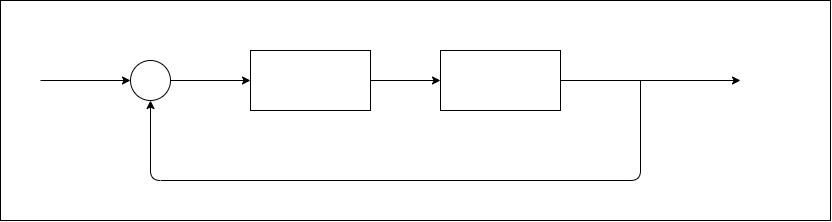

In [7]:
Image(filename='figs/diagrama_de_blocos.drawio.png')